In [1]:
import torch
import math
#from dlc_practical_prologue import *
#torch.set_grad_enabled(False)

In [15]:
#INTERESTING FACT: WHEN COMPUTING THE BATCH GRADIENT PYTORCH DOES NOT TAKE THE SUM OF THE GRADIENTA OF SINGLE DATA POINTS
#BUT THE MEAN. I LEART AT THE EXPENSE OF ABOUT 1H LOL 

In [16]:
class Parameter():
    def __init__(self):
        self.name = ''
        self.data = None
        self.grad = None

In [17]:
class Module(object):
    def forward (self, *input):
        raise NotImplementedError
        
    def backward ( self , * gradwrtoutput ) :
        raise NotImplementedError
    
    def get_parameters( self ) :
        return []   

In [18]:
class Losses(object):        
    def forward():
        return NotImplementedError
    def backward():
        NotImplementedError

In [19]:
class Optimizer(object):
    def zero_grad(self):
        for parameter in self.param : 
            parameter.grad = 0
            
    def step(self):
        raise NotImplementedError

In [20]:
class SGD(Optimizer):
    # this is a SGD optimizer
    def __init__(self,lr,max_iter, parameters) :  
        super().__init__()
        self.eta = lr
        self.maxStep = max_iter 
        self.param = parameters
        self.number_step = 0

    def step(self): 
        if self.number_step <=self.maxStep:
            for parameter in self.param :
                parameter.data = parameter.data - self.eta * parameter.grad
            self.number_step = self.number_step + 1
        return self.param

In [21]:
class Linear(Module):
    
    def __init__(self, input_dim, out_dim, bias = True):
        super().__init__()
        std = 1/math.sqrt(input_dim)
        self.weight = Parameter()
        self.parameters = []
        
        self.weight.data = torch.rand(out_dim, input_dim)
        self.weight.data = 2*std*self.weight.data - std
        self.weight.name = 'weight'
        self.parameters += [self.weight]
        
        self.with_bias = bias
        if bias :
            self.bias = Parameter()
            self.bias.data = torch.rand(out_dim)
            self.bias.data = 2*std*self.bias.data - std
            self.bias.data = self.bias.data.unsqueeze(0)
            self.bias.name = 'bias'
            self.parameters +=[self.bias]
            
        self.x = None
              
    def forward(self, x):
        self.x = x
        self.batch_size = x.shape[0]
        return self.x.mm(self.weight.data.T) + self.bias.data
        
    def backward(self, prev_grad):
        
        prev_grad = prev_grad.view(self.batch_size, -1, 1)
        #print(prev_grad.shape)
        if self.x is None:
            raise CallForwardFirst
        
        if self.weight.grad is None:
            self.weight.grad = torch.zeros_like(self.weight.data)
        
        grad_on_batch = prev_grad.view(self.batch_size, -1, 1)*self.x.view(self.batch_size, 1, -1)
        self.weight.grad += grad_on_batch.mean(0)
        
        if self.with_bias:
            if self.bias.grad is None:
                self.bias.grad = torch.zeros_like(self.bias.data)
            grad_on_batch = prev_grad.view(self.batch_size, -1)
            self.bias.grad += grad_on_batch.mean(0)
        
        #if the output has dimension one, squeezing creates problems
        if prev_grad.shape[1]>1:
            prev_grad = prev_grad.squeeze()
        next_grad = prev_grad@self.weight.data
        return next_grad.squeeze()
    
    def get_parameters(self):
        return self.parameters    

In [22]:
class Tanh(Module):
    def __init__(self):
        self.x = None
    
    def forward (self, x):
        self.x = x
        return torch.tanh(x)
        
    def backward ( self, prev_grad) :
        if self.x is None:
            raise CallForwardFirst
            
        def d(x):
            return 4 * (x.exp() + x.mul(-1).exp()).pow(-2)
        
        return d(self.x)*prev_grad
            

In [23]:
class ReLu(Module):
    def __init__(self):
        self.x = None
    
    def forward (self, x):
        self.x = x
        x[x<0]=0
        return x
        
    def backward ( self, prev_grad) :
        if self.x is None:
            raise CallForwardFirst
            
        def d(x):
            x[x<0]=0
            x[x>0]=1
            return x
        
        return d(self.x)*prev_grad
            

In [24]:
x = torch.randn(5, 5)
y = x.clone()
y[y<0] = 0
x, y

(tensor([[ 0.8904,  0.9226,  0.9735,  0.5800, -0.4941],
         [-0.0555, -0.8688, -0.6625,  0.1297, -0.5309],
         [ 0.7964, -2.3508,  0.8163, -0.4328,  1.1595],
         [-1.0723, -0.0455, -0.9628,  2.6265,  0.6534],
         [-0.4571,  1.5463,  1.8305,  0.1868,  1.3160]]),
 tensor([[0.8904, 0.9226, 0.9735, 0.5800, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.1297, 0.0000],
         [0.7964, 0.0000, 0.8163, 0.0000, 1.1595],
         [0.0000, 0.0000, 0.0000, 2.6265, 0.6534],
         [0.0000, 1.5463, 1.8305, 0.1868, 1.3160]]))

In [113]:
#Doesn't work and we have to output 1 unit so it's useless
class Softmax(Module):
    def __init__(self):
        self.x = None
    
    def forward (self, x):
        self.x = x
        return torch.softmax(x,1)
    
    def d(self, x):
            s = x.softmax(1)
            temp = s.unsqueeze(-1)
            off_diag = temp.view(-1,1, temp.shape[1] )*temp
            diag = torch.diag_embed(torch.diagonal(temp, dim1 = 1, dim2 = 2).sqrt()) 
            return diag - off_diag
        
    def backward ( self, prev_grad) :
        if self.x is None:
            raise CallForwardFirst
            
        def d(x):
            s = x.softmax(1)
            temp = s.unsqueeze(-1)
            off_diag = temp.view(-1,1, temp.shape[1] )*temp
            diag = torch.diag_embed(torch.diagonal(temp, dim1 = 1, dim2 = 2).sqrt()) 
            return -diag + off_diag
        print(d(self.x).shape, prev_grad.T.shape)
        return torch.einsum('b ij, bj -> bi', d(self.x),prev_grad)

In [114]:
x = torch.randn(1, 5, requires_grad = True)
soft = Softmax()
s_b = x.softmax(1)
s_h = soft.forward(x.clone())
print('check on the values:\n', s_b ,'\n', s_h, 'diff:\n', abs(s_b-s_h) )

soft.backward(torch.ones(1, 5))
torch.autograd.grad(s_b[0,0], x, retain_graph = True), soft.d(x)

check on the values:
 tensor([[0.0553, 0.1815, 0.2808, 0.4004, 0.0820]], grad_fn=<SoftmaxBackward>) 
 tensor([[0.0553, 0.1815, 0.2808, 0.4004, 0.0820]], grad_fn=<SoftmaxBackward>) diff:
 tensor([[0., 0., 0., 0., 0.]], grad_fn=<AbsBackward>)
torch.Size([1, 5, 5]) torch.Size([5, 1])


((tensor([[ 0.0523, -0.0100, -0.0155, -0.0222, -0.0045]]),),
 tensor([[[0.2322, 0.2252, 0.2197, 0.2131, 0.2307],
          [0.2252, 0.2023, 0.1843, 0.1626, 0.2204],
          [0.2197, 0.1843, 0.1564, 0.1228, 0.2122],
          [0.2131, 0.1626, 0.1228, 0.0749, 0.2024],
          [0.2307, 0.2204, 0.2122, 0.2024, 0.2285]]], grad_fn=<SubBackward0>))

In [52]:
a = 1.*torch.arange(25).view(5, 5).unsqueeze(0)
a = torch.cat((a, a, a), dim = 0)
torch.diag_embed(torch.diagonal(a, dim1 = 1, dim2 = 2).sqrt()) + a

tensor([[[ 0.,  1.,  2.,  3.,  4.],
         [ 5., 12.,  7.,  8.,  9.],
         [10., 11., 24., 13., 14.],
         [15., 16., 17., 36., 19.],
         [20., 21., 22., 23., 48.]],

        [[ 0.,  1.,  2.,  3.,  4.],
         [ 5., 12.,  7.,  8.,  9.],
         [10., 11., 24., 13., 14.],
         [15., 16., 17., 36., 19.],
         [20., 21., 22., 23., 48.]],

        [[ 0.,  1.,  2.,  3.,  4.],
         [ 5., 12.,  7.,  8.,  9.],
         [10., 11., 24., 13., 14.],
         [15., 16., 17., 36., 19.],
         [20., 21., 22., 23., 48.]]])

In [34]:
soft = Softmax()
x = torch.randn(1, 5, requires_grad = True)
s = x.softmax(1)
s.backward()
x.grad


RuntimeError: grad can be implicitly created only for scalar outputs

In [131]:
#Doesn't work and we have to output 1 unit so it's useless
class Sigmoid(Module):
    def __init__(self):
        self.x = None
    
    def forward (self, x):
        self.x = x
        return torch.sigmoid(x)
        
    def backward ( self, prev_grad) :
        if self.x is None:
            raise CallForwardFirst
            
        def d(x):
            y=torch.sigmoid(x)
            return y*(1-y)
        
        return d(self.x)*prev_grad

In [110]:
class MSE(Losses):
    # Attention! Works well only when the vectors provided are of the form [batch_size, vector dimension]
    # Otherwise it doesn know what dimesion to pick for the mean computation
    # I'll fix this later
    def __init__(self):
        self.x = None
    def forward(self, x, t):
        self.x = x
        self.t = t
        return (x - t).pow(2).mean()
    
    def backward(self):
        if self.x == None or self.t == None:
            raise CallForwardFirst
        return 2 * (self.x - self.t)/self.x.shape[1]

In [128]:
class Sequential(object):
    def __init__(self, modules):
        super().__init__()
        self.modules=modules
        self.parameters = []
        for m in self.modules:
            param = m.get_parameters()
            if param:
                self.parameters += param
        
    def forward(self,x):
        for m in self.modules:
            x=m.forward(x)
        return x
    
    def backward(self, loss_grad):
        x = loss_grad
        for m in reversed(self.modules):
            #print(m)
            x = m.backward(x)
            
    def get_parameters(self):
        return self.parameters

    def set_parameters(self , params):
        self.parameters = params
        

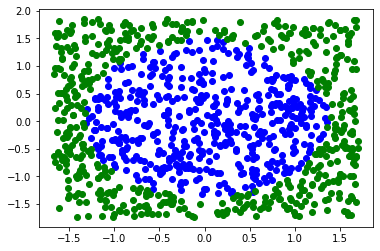

In [72]:
def generate_disc_set(nb):
    input_ = torch.empty(nb, 2).uniform_(0, 1)
    target = (input_-0.5).pow(2).sum(1).sub(1 / (math.pi*2)).sign().add(1).div(2).long()
    return input_, target
input_data, output_data=generate_disc_set(1000)
output_data=1-output_data
input_data-=input_data.mean(0)
input_data/=input_data.std(0)
import matplotlib.pyplot as plt
plt.plot(input_data[:,0][output_data==1],input_data[:,1][output_data==1],'bo')
plt.plot(input_data[:,0][output_data!=1],input_data[:,1][output_data!=1],'go')

In [73]:
#output_data = 2*output_data -1
print(input_data, input_data.shape, output_data.shape)

tensor([[-0.2653,  0.9834],
        [-1.2886, -1.7250],
        [ 0.6601,  1.0128],
        ...,
        [-0.2250,  0.4314],
        [-0.4552, -1.4729],
        [ 0.1431,  1.3598]]) torch.Size([1000, 2]) torch.Size([1000])


In [74]:
#we should use one hot label embedding with MSELoss. Hence it is necessary to implement a Softmax
#Maybe we should also implement CrossEntropyLoss
#print(input_data.shape, output_data.shape)
#output_data = convert_to_one_hot_labels(input_data, output_data)
#print(input_data.shape, output_data.shape)

In [75]:
#handmade sequential linear + relu 
linear1 = Linear(2, 25, True)
linear2 = Linear(25,25,True)
linear3 = Linear(25,1,True)
sigma1 = Tanh()
sigma2 = Tanh()
sigma3 = Tanh()
loss = MSE()

net = Sequential([
    linear1, 
    sigma1 ,
    linear2,
    sigma2 ,
    linear3,
    sigma3 ,
])

In [76]:
optimizer = SGD(lr = 1e-4,max_iter = 100, parameters = net.get_parameters())
n=10**2
N=output_data.shape[0]
for t in range(n):
    optimizer.zero_grad()
    acc_loss=0
    permuted_index = torch.randperm(input_data.size()[0])
    input_data_shuffled = input_data[permuted_index]
    output_data_shuffled = output_data[permuted_index]
    for i in range(N):
        x=input_data_shuffled[i]
        y=2*output_data_shuffled[i]-1
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = net.forward(x.unsqueeze(0))
        # Compute and print loss.
        acc_loss += loss.forward(y_pred,y.unsqueeze(0))
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        net.backward(loss.backward())

    # Calling the step function on an Optimizer makes an update to its parameters
    new_par = optimizer.step()
    #print(len(new_par))
    net.set_parameters(new_par)
    
    
    if t%10==0:
        print(t, '   MSE loss = ' , acc_loss.item())

0    MSE loss =  1049.139892578125
10    MSE loss =  951.9638671875
20    MSE loss =  897.6994018554688
30    MSE loss =  828.3200073242188
40    MSE loss =  743.03173828125
50    MSE loss =  649.316650390625
60    MSE loss =  559.2086181640625
70    MSE loss =  481.24493408203125
80    MSE loss =  417.7786865234375
90    MSE loss =  367.5589599609375


In [77]:
correct=0
for i in range(output_data.shape[0]):
        x=input_data[i]
        y=2*output_data[i]-1
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = net.forward(x.unsqueeze(0))
        if abs(y_pred-output_data[i])<1:
            correct+=1
print('Correct predictions after '+str(n)+' training steps: '+str(correct/N*100)+' %')

Correct predictions after 100 training steps: 96.7 %


In [96]:
#Reinitialize net
#handmade sequential linear + relu 
linear1 = Linear(2, 25, True)
linear2 = Linear(25,25,True)
linear3 = Linear(25,1,True)
sigma1 = Tanh()
sigma2 = Tanh()
sigma3 = Tanh()
loss = MSE()

net = Sequential([
    linear1, 
    sigma1 ,
    linear2,
    sigma2 ,
    linear3,
    sigma3 ,
])

In [97]:
optimizer = SGD(lr = 1e-1,max_iter = 100, parameters = net.get_parameters())
n=10**2
N=output_data.shape[0]
batch_size = 100
for t in range(n):
    acc_loss=0
    permuted_index = torch.randperm(input_data.size()[0])
    input_data_shuffled = input_data[permuted_index]
    output_data_shuffled = output_data[permuted_index]
    for b in range(0, N, batch_size):
        predictions = net.forward(input_data_shuffled[b:b+batch_size])
        l= loss.forward(predictions, output_data_shuffled[b:b+batch_size].unsqueeze(-1))
        acc_loss += l
        optimizer.zero_grad()
        
        net.backward(loss.backward())
        
        new_par = optimizer.step()
        net.set_parameters(new_par)
    
    print(t, '   MSE loss = ' , acc_loss.item())

0    MSE loss =  2.6662144660949707
1    MSE loss =  2.2822318077087402
2    MSE loss =  2.215752363204956
3    MSE loss =  2.156341552734375
4    MSE loss =  2.093371868133545
5    MSE loss =  2.023648262023926
6    MSE loss =  1.9451017379760742
7    MSE loss =  1.8829989433288574
8    MSE loss =  1.79679274559021
9    MSE loss =  1.7139122486114502
10    MSE loss =  1.6537455320358276
11    MSE loss =  1.6488524675369263
12    MSE loss =  1.6488525867462158
13    MSE loss =  1.6488524675369263
14    MSE loss =  1.6488525867462158
15    MSE loss =  1.6488525867462158
16    MSE loss =  1.6488524675369263
17    MSE loss =  1.6488524675369263
18    MSE loss =  1.6488527059555054
19    MSE loss =  1.6488525867462158
20    MSE loss =  1.6488524675369263
21    MSE loss =  1.6488525867462158
22    MSE loss =  1.6488525867462158
23    MSE loss =  1.6488524675369263
24    MSE loss =  1.6488525867462158
25    MSE loss =  1.6488525867462158
26    MSE loss =  1.6488525867462158
27    MSE loss = 

In [98]:
correct=0
for i in range(output_data.shape[0]):
        x=input_data[i]
        y=2*output_data[i]-1
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = net.forward(x.unsqueeze(0))
        if abs(y_pred-output_data[i])<1:
            correct+=1
print('Correct predictions after '+str(n)+' training steps: '+str(correct/N*100)+' %')

Correct predictions after 100 training steps: 100.0 %


In [132]:
#handmade sequential linear + relu with sigmoid to end and no batches
linear1 = Linear(2, 25, True)
linear2 = Linear(25,25,True)
linear3 = Linear(25,1,True)
sigma1 = ReLu()
sigma2 = ReLu()
sigma3 = Sigmoid()
loss = MSE()

net = Sequential([
    linear1, 
    sigma1 ,
    linear2,
    sigma2 ,
    linear3,
    sigma3 ,
])
optimizer = SGD(lr = 1e-4,max_iter = 100, parameters = net.get_parameters())
n=10**2
N=output_data.shape[0]
for t in range(n):
    optimizer.zero_grad()
    acc_loss=0
    permuted_index = torch.randperm(input_data.size()[0])
    input_data_shuffled = input_data[permuted_index]
    output_data_shuffled = output_data[permuted_index]
    for i in range(N):
        x=input_data_shuffled[i]
        y=output_data_shuffled[i]
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = net.forward(x.unsqueeze(0))
        # Compute and print loss.
        acc_loss += loss.forward(y_pred,y.unsqueeze(0))
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        net.backward(loss.backward())

    # Calling the step function on an Optimizer makes an update to its parameters
    new_par = optimizer.step()
    #print(len(new_par))
    net.set_parameters(new_par)
    
    
    if t%10==0:
        print(t, '   MSE loss = ' , acc_loss.item())
    
correct=0
for i in range(output_data.shape[0]):
        x=input_data[i]
        y=2*output_data[i]-1
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = net.forward(x.unsqueeze(0))
        if abs(y_pred-output_data[i])<1:
            correct+=1
print('Correct predictions after '+str(n)+' training steps: '+str(correct/N*100)+' %')

0    MSE loss =  253.6742401123047
10    MSE loss =  250.0392303466797
20    MSE loss =  247.07595825195312
30    MSE loss =  244.49795532226562
40    MSE loss =  242.05059814453125
50    MSE loss =  239.64300537109375
60    MSE loss =  237.228759765625
70    MSE loss =  234.7724151611328
80    MSE loss =  232.2540283203125
90    MSE loss =  229.65501403808594
Correct predictions after 100 training steps: 100.0 %


In [133]:
#handmade sequential linear + relu with softmax with batches
linear1 = Linear(2, 25, True)
linear2 = Linear(25,25,True)
linear3 = Linear(25,1,True)
sigma1 = ReLu()
sigma2 = ReLu()
sigma3 = Sigmoid()
loss = MSE()

net = Sequential([
    linear1, 
    sigma1 ,
    linear2,
    sigma2 ,
    linear3,
    sigma3 ,
])
optimizer = SGD(lr = 1e-1,max_iter = 100, parameters = net.get_parameters())
n=10**2
N=output_data.shape[0]
batch_size = 100
for t in range(n):
    acc_loss=0
    permuted_index = torch.randperm(input_data.size()[0])
    input_data_shuffled = input_data[permuted_index]
    output_data_shuffled = output_data[permuted_index]
    for b in range(0, N, batch_size):
        predictions = net.forward(input_data_shuffled[b:b+batch_size])
        l= loss.forward(predictions, output_data_shuffled[b:b+batch_size].unsqueeze(-1))
        acc_loss += l
        optimizer.zero_grad()
        
        net.backward(loss.backward())
        
        new_par = optimizer.step()
        net.set_parameters(new_par)
    
    print(t, '   MSE loss = ' , acc_loss.item())
    
correct=0
for i in range(output_data.shape[0]):
        x=input_data[i]
        y=2*output_data[i]-1
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = net.forward(x.unsqueeze(0))
        if abs(y_pred-output_data[i])<1:
            correct+=1
print('Correct predictions after '+str(n)+' training steps: '+str(correct/N*100)+' %')

0    MSE loss =  2.4813714027404785
1    MSE loss =  2.46077036857605
2    MSE loss =  2.4431357383728027
3    MSE loss =  2.427443265914917
4    MSE loss =  2.4113965034484863
5    MSE loss =  2.3954713344573975
6    MSE loss =  2.3800158500671387
7    MSE loss =  2.3642022609710693
8    MSE loss =  2.3473432064056396
9    MSE loss =  2.3301541805267334
10    MSE loss =  2.319033145904541
11    MSE loss =  2.318113327026367
12    MSE loss =  2.318113088607788
13    MSE loss =  2.318113088607788
14    MSE loss =  2.318113088607788
15    MSE loss =  2.318112850189209
16    MSE loss =  2.318113088607788
17    MSE loss =  2.318112850189209
18    MSE loss =  2.318113088607788
19    MSE loss =  2.318113088607788
20    MSE loss =  2.318113088607788
21    MSE loss =  2.318113327026367
22    MSE loss =  2.318112850189209
23    MSE loss =  2.318113327026367
24    MSE loss =  2.318113088607788
25    MSE loss =  2.318113088607788
26    MSE loss =  2.318112850189209
27    MSE loss =  2.31811285018